# Airbyte SQL Index Guide

We will show how to generate SQL queries on a Snowflake db generated by Airbyte.

In [ ]:
# Uncomment to enable debugging.

# import logging
# import sys

# logging.basicConfig(stream=sys.stdout, level=logging.DEBUG)
# logging.getLogger().addHandler(logging.StreamHandler(stream=sys.stdout))

### Airbyte ingestion

Here we show how to ingest data from Github into a Snowflake db using Airbyte.

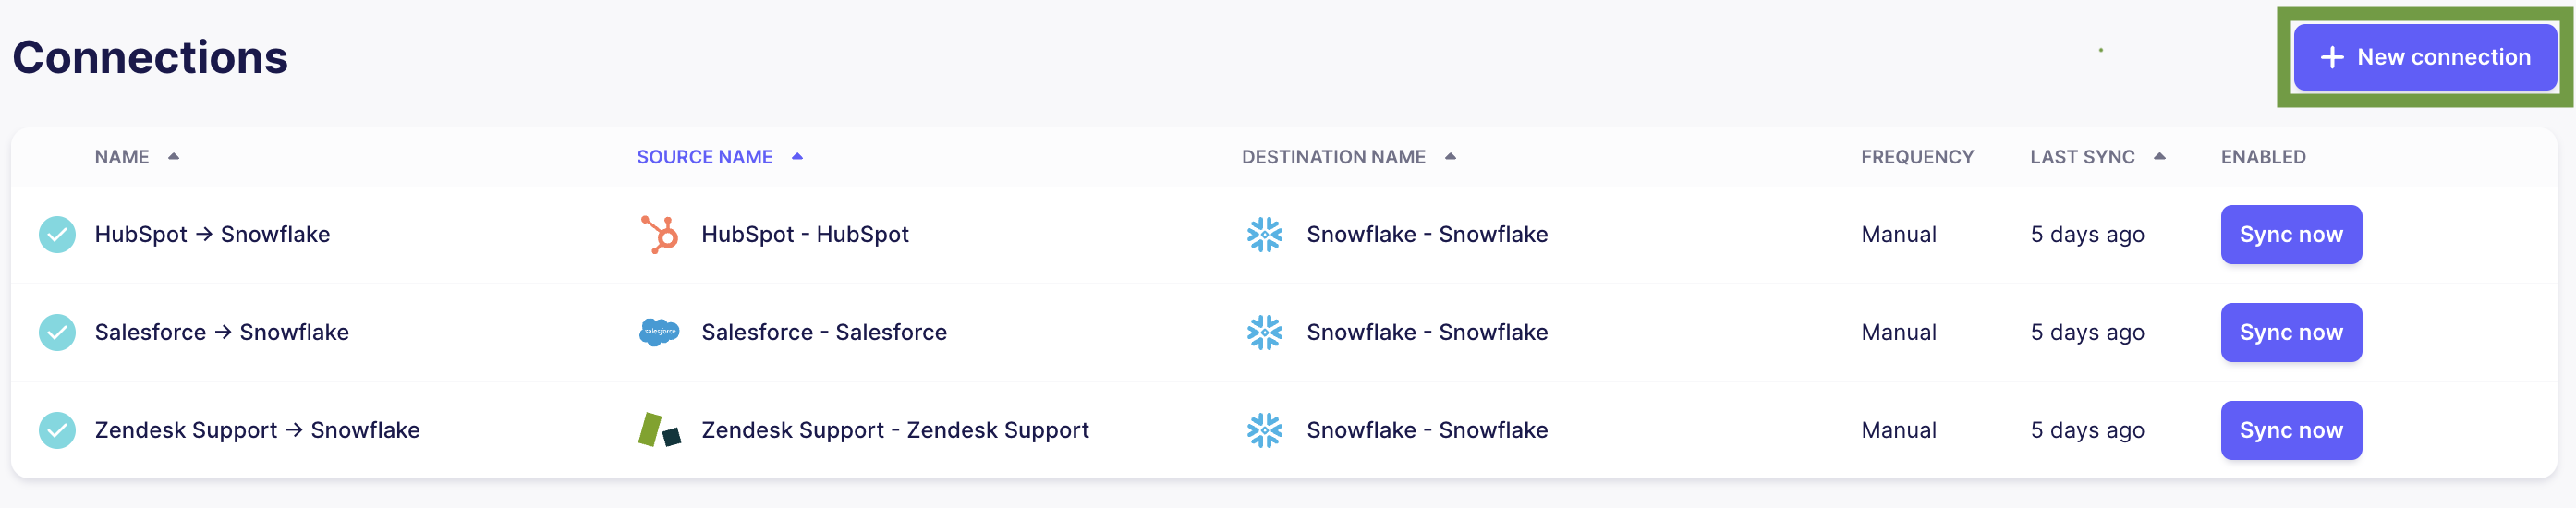

In [ ]:
from IPython.display import Image

Image(filename="img/airbyte_1.png")

Let's create a new connection. Here we will be dumping our Zendesk tickets into a Snowflake db.

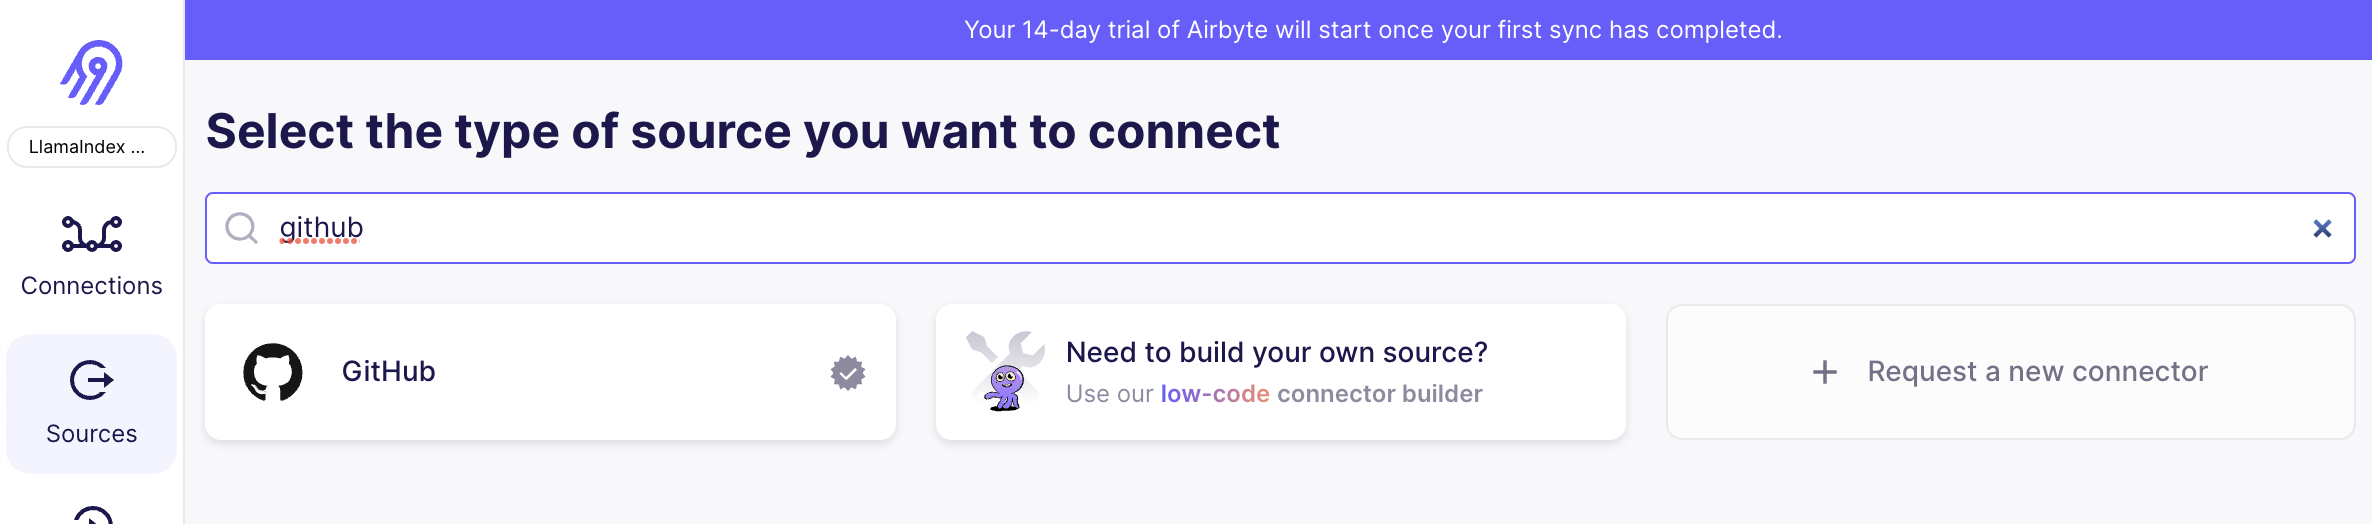

In [ ]:
Image(filename="img/github_1.png")

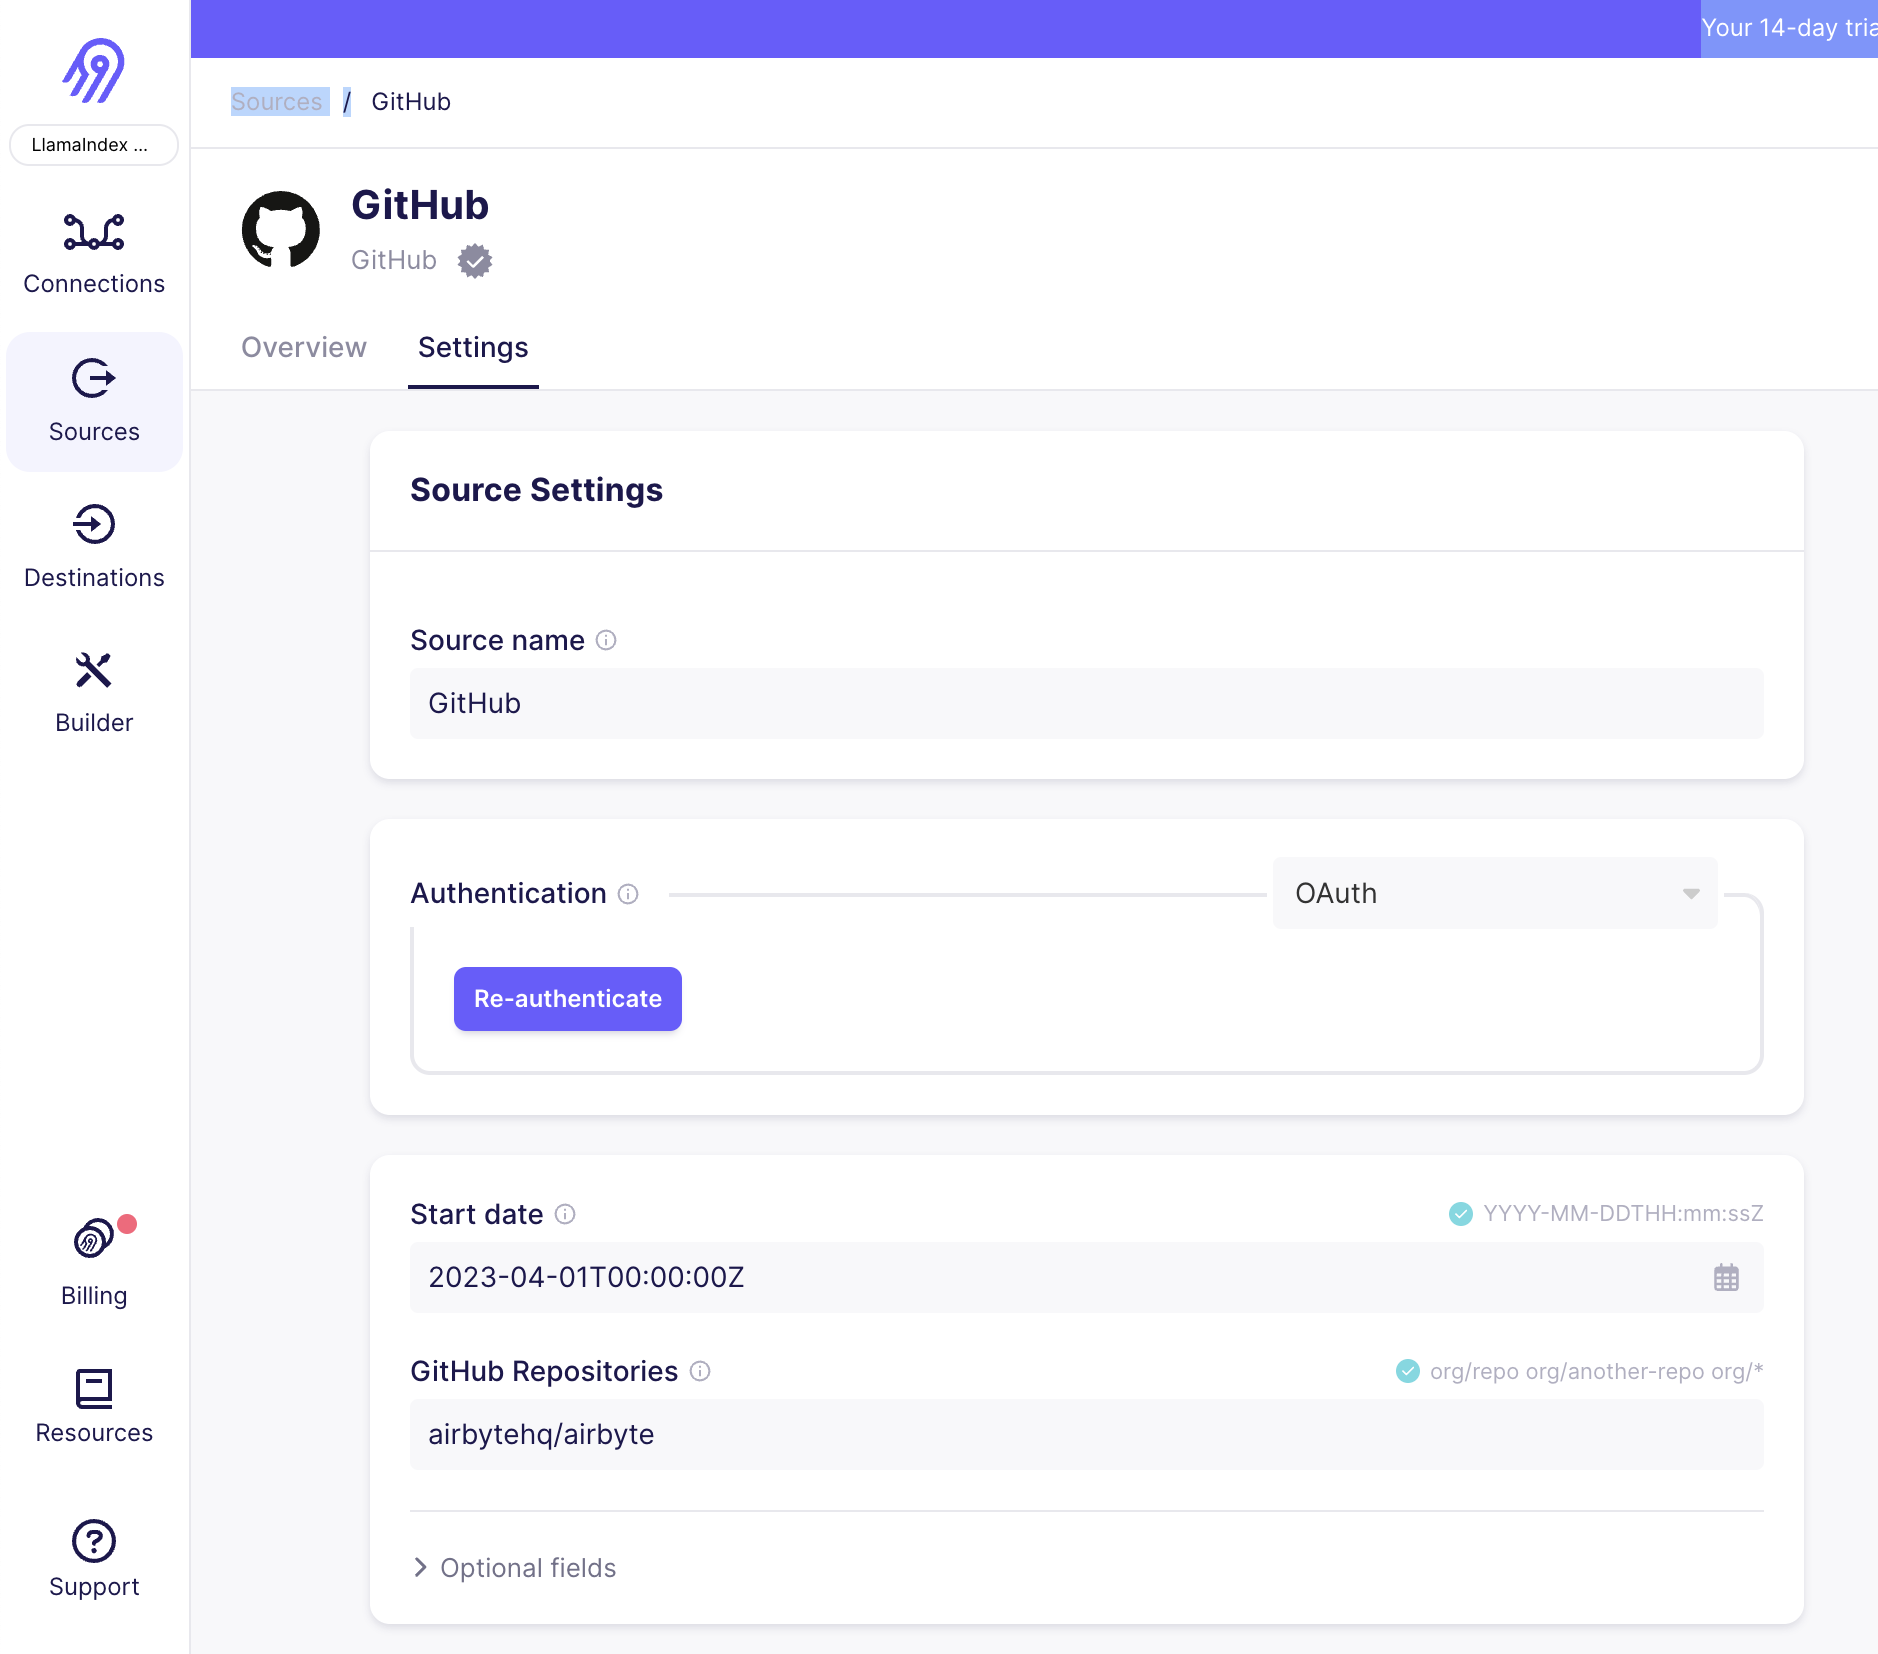

In [ ]:
Image(filename="img/github_2.png")

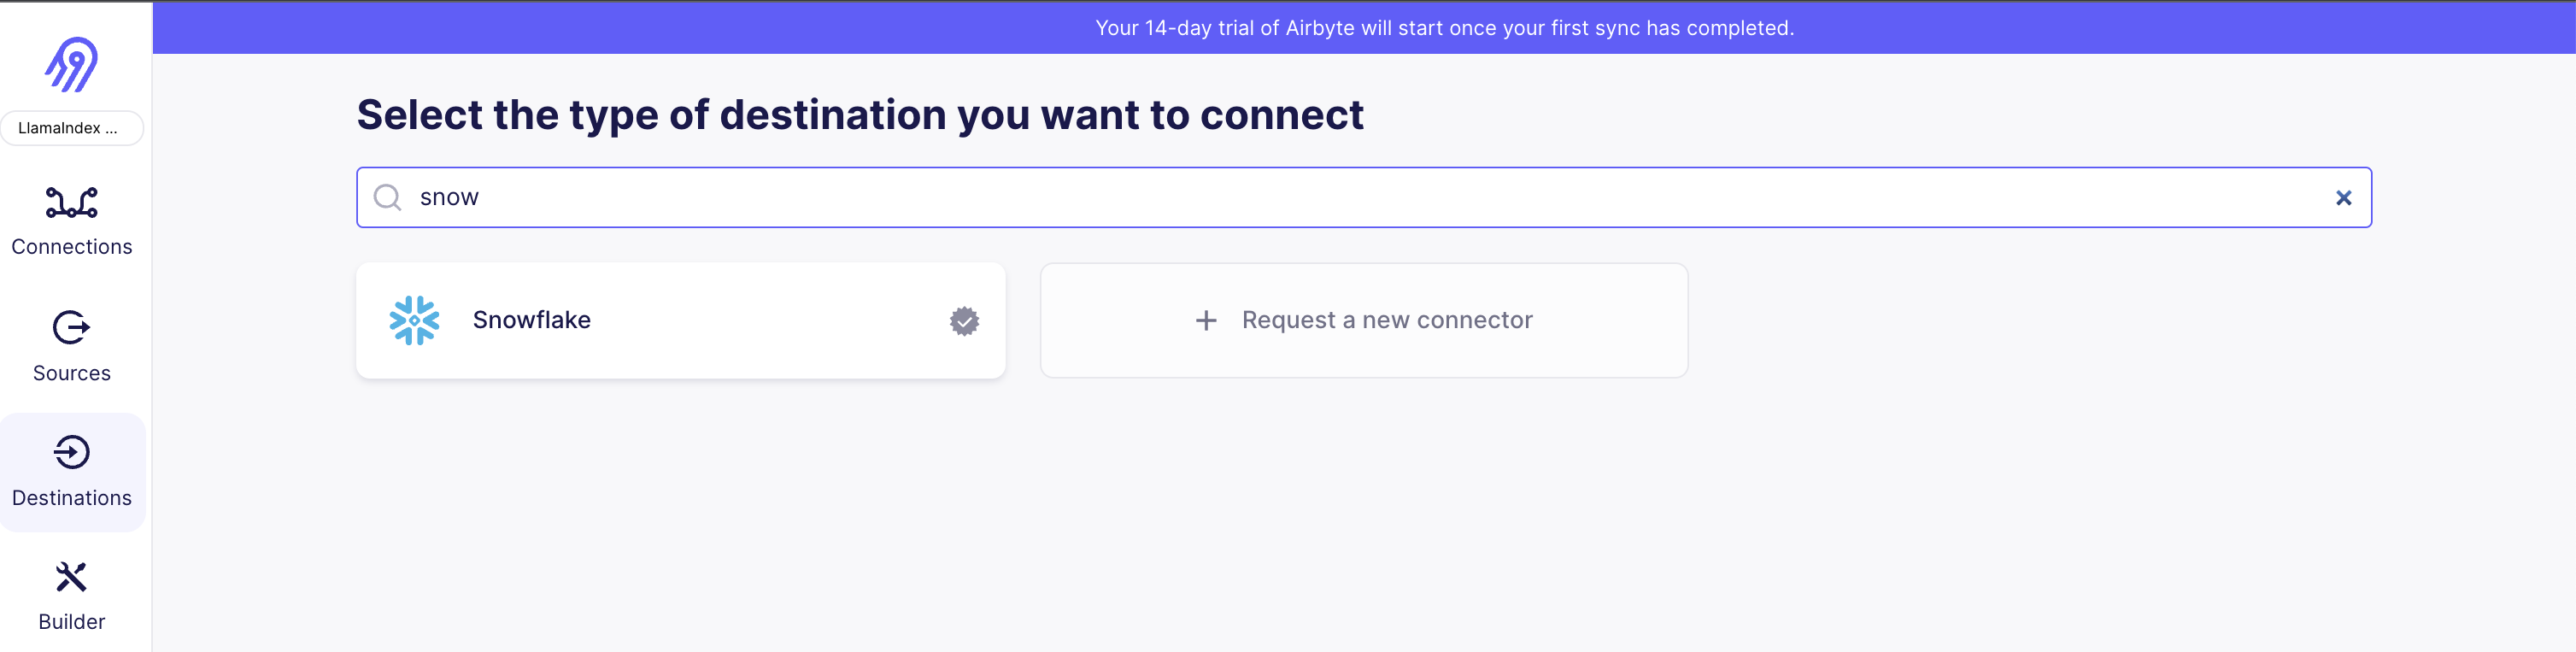

In [ ]:
Image(filename="img/snowflake_1.png")

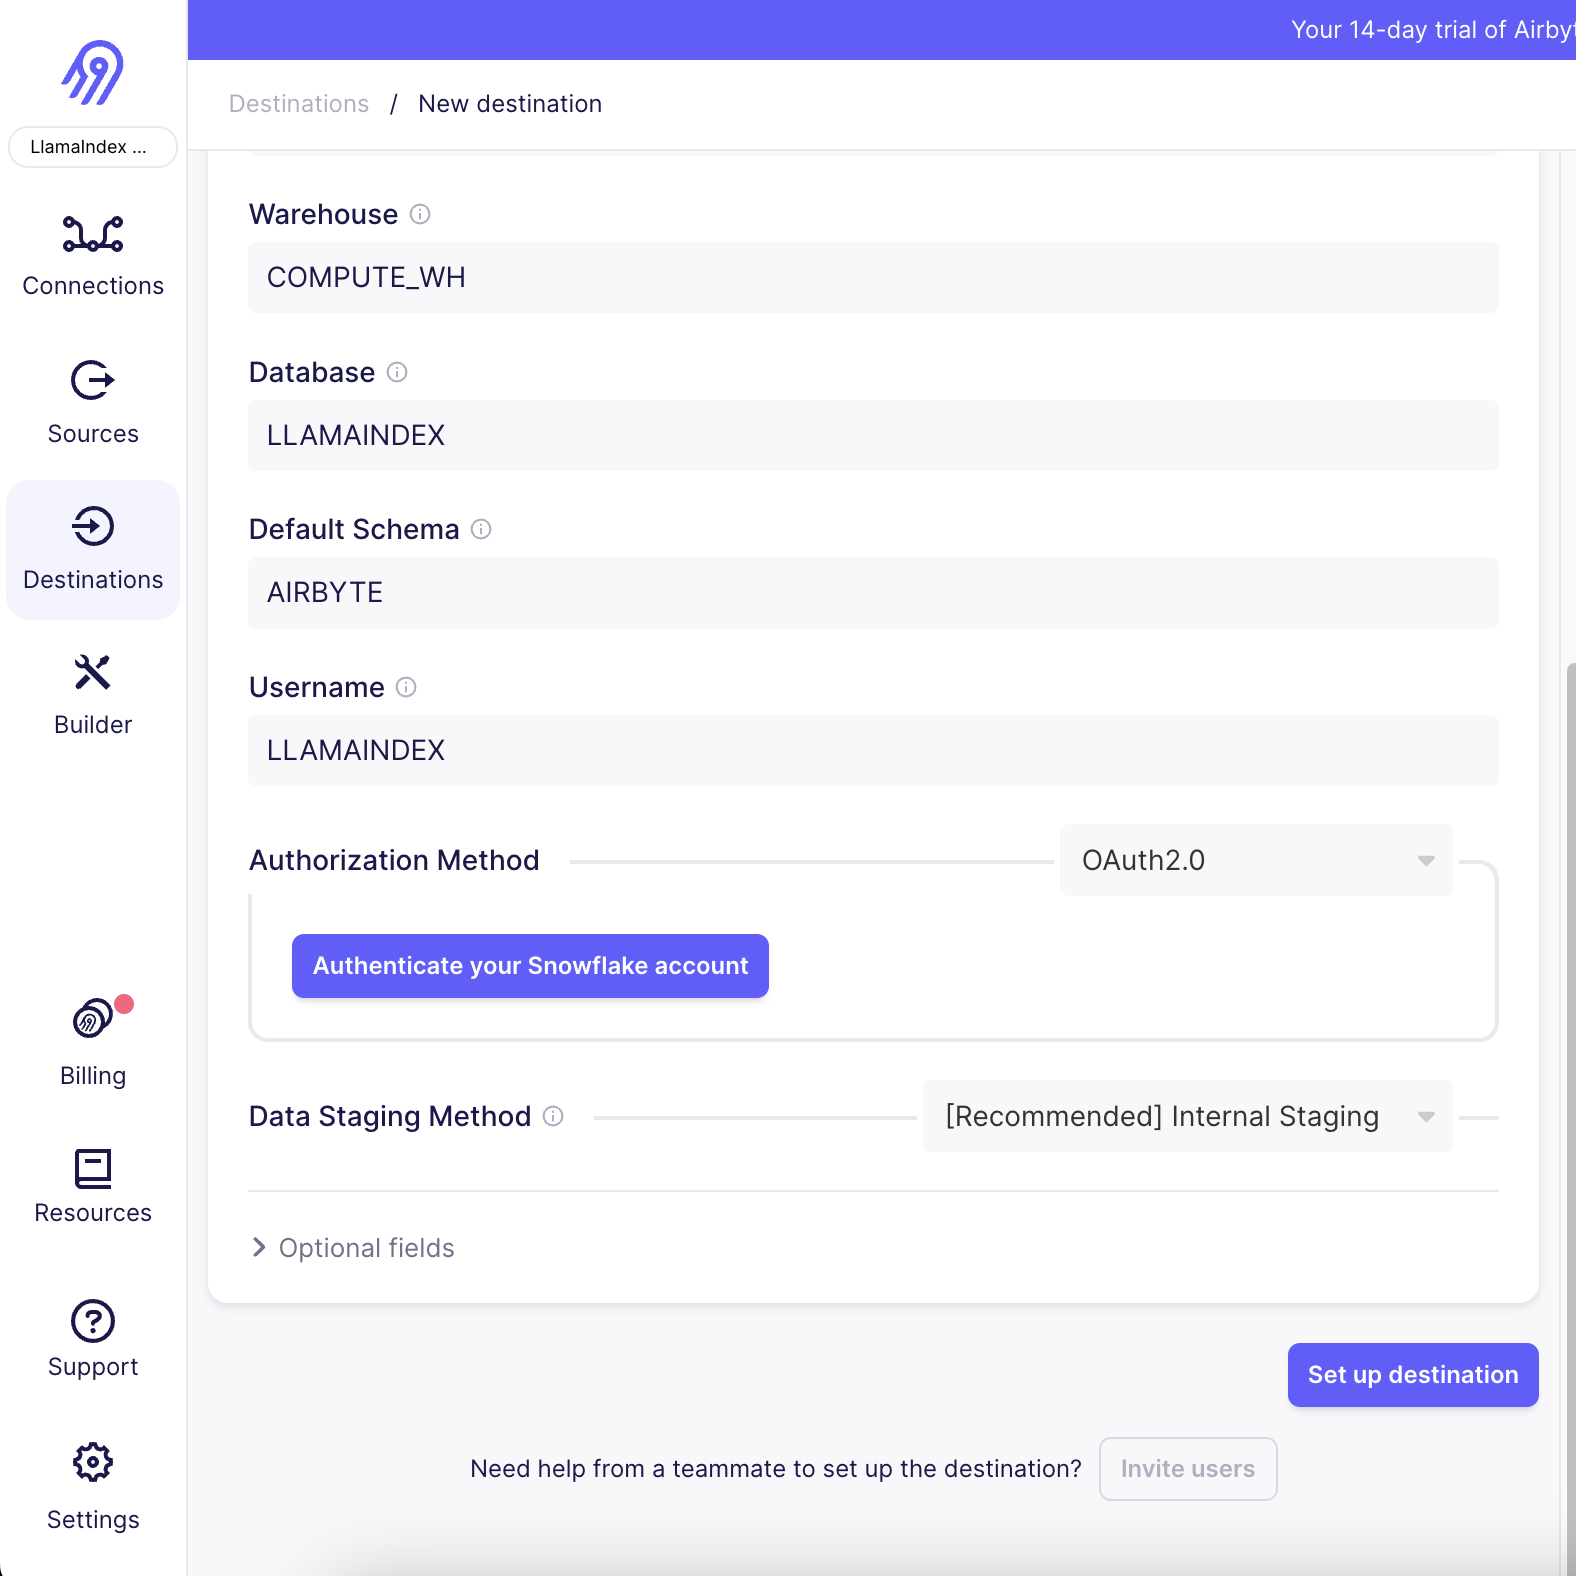

In [ ]:
Image(filename="img/snowflake_2.png")

Choose the streams you want to sync.

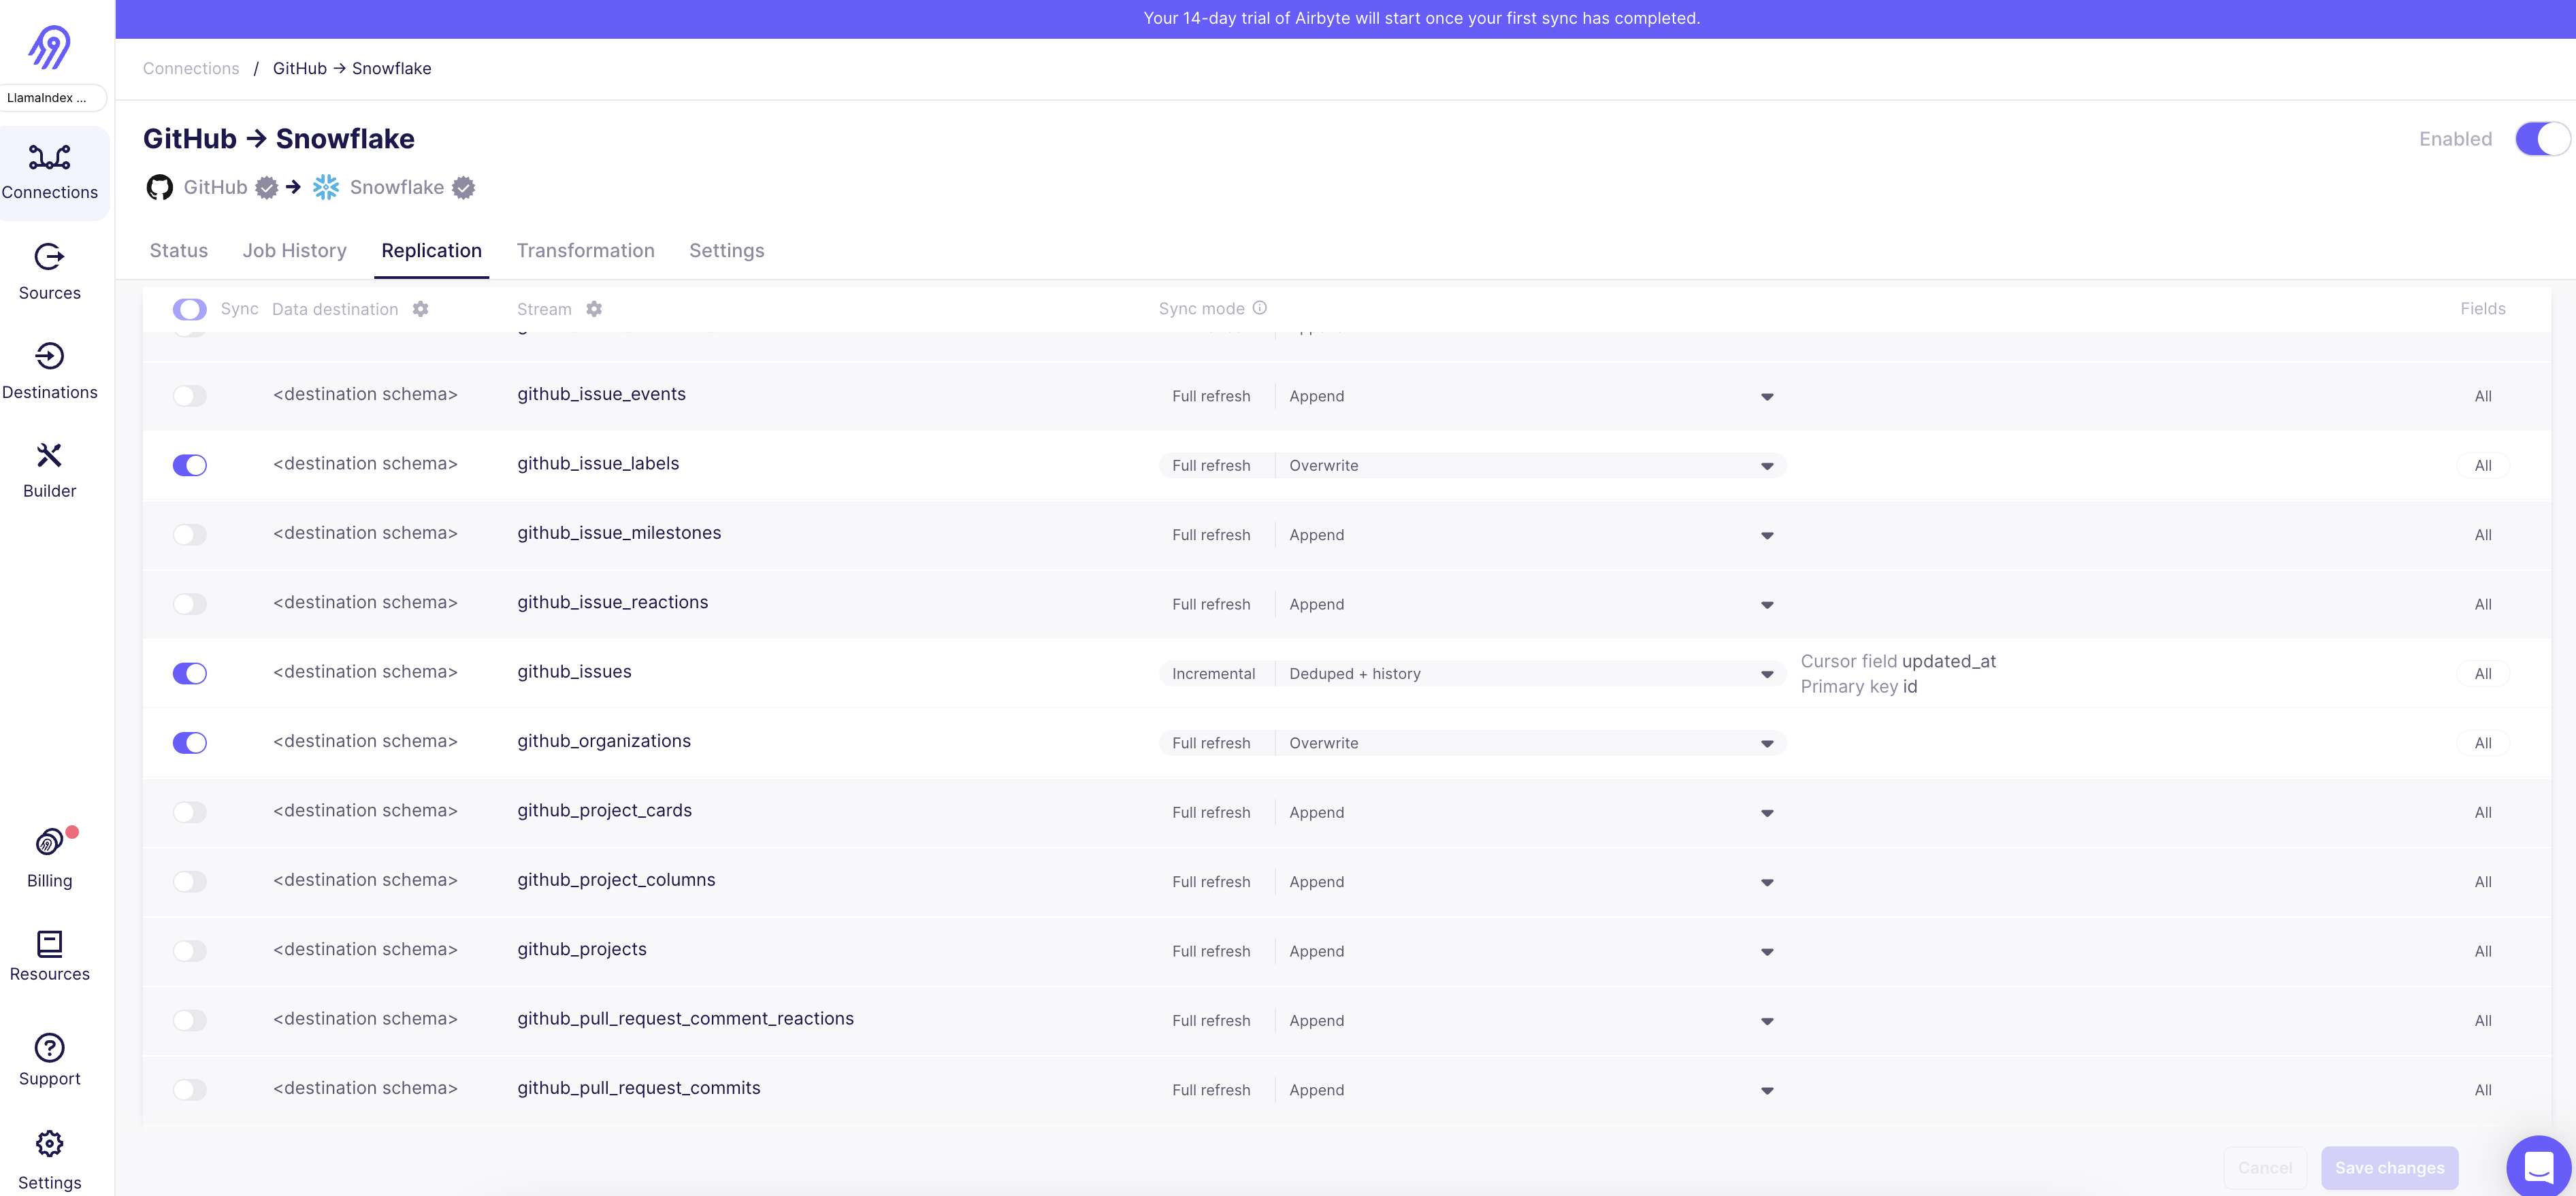

In [ ]:
Image(filename="img/airbyte_7.png")

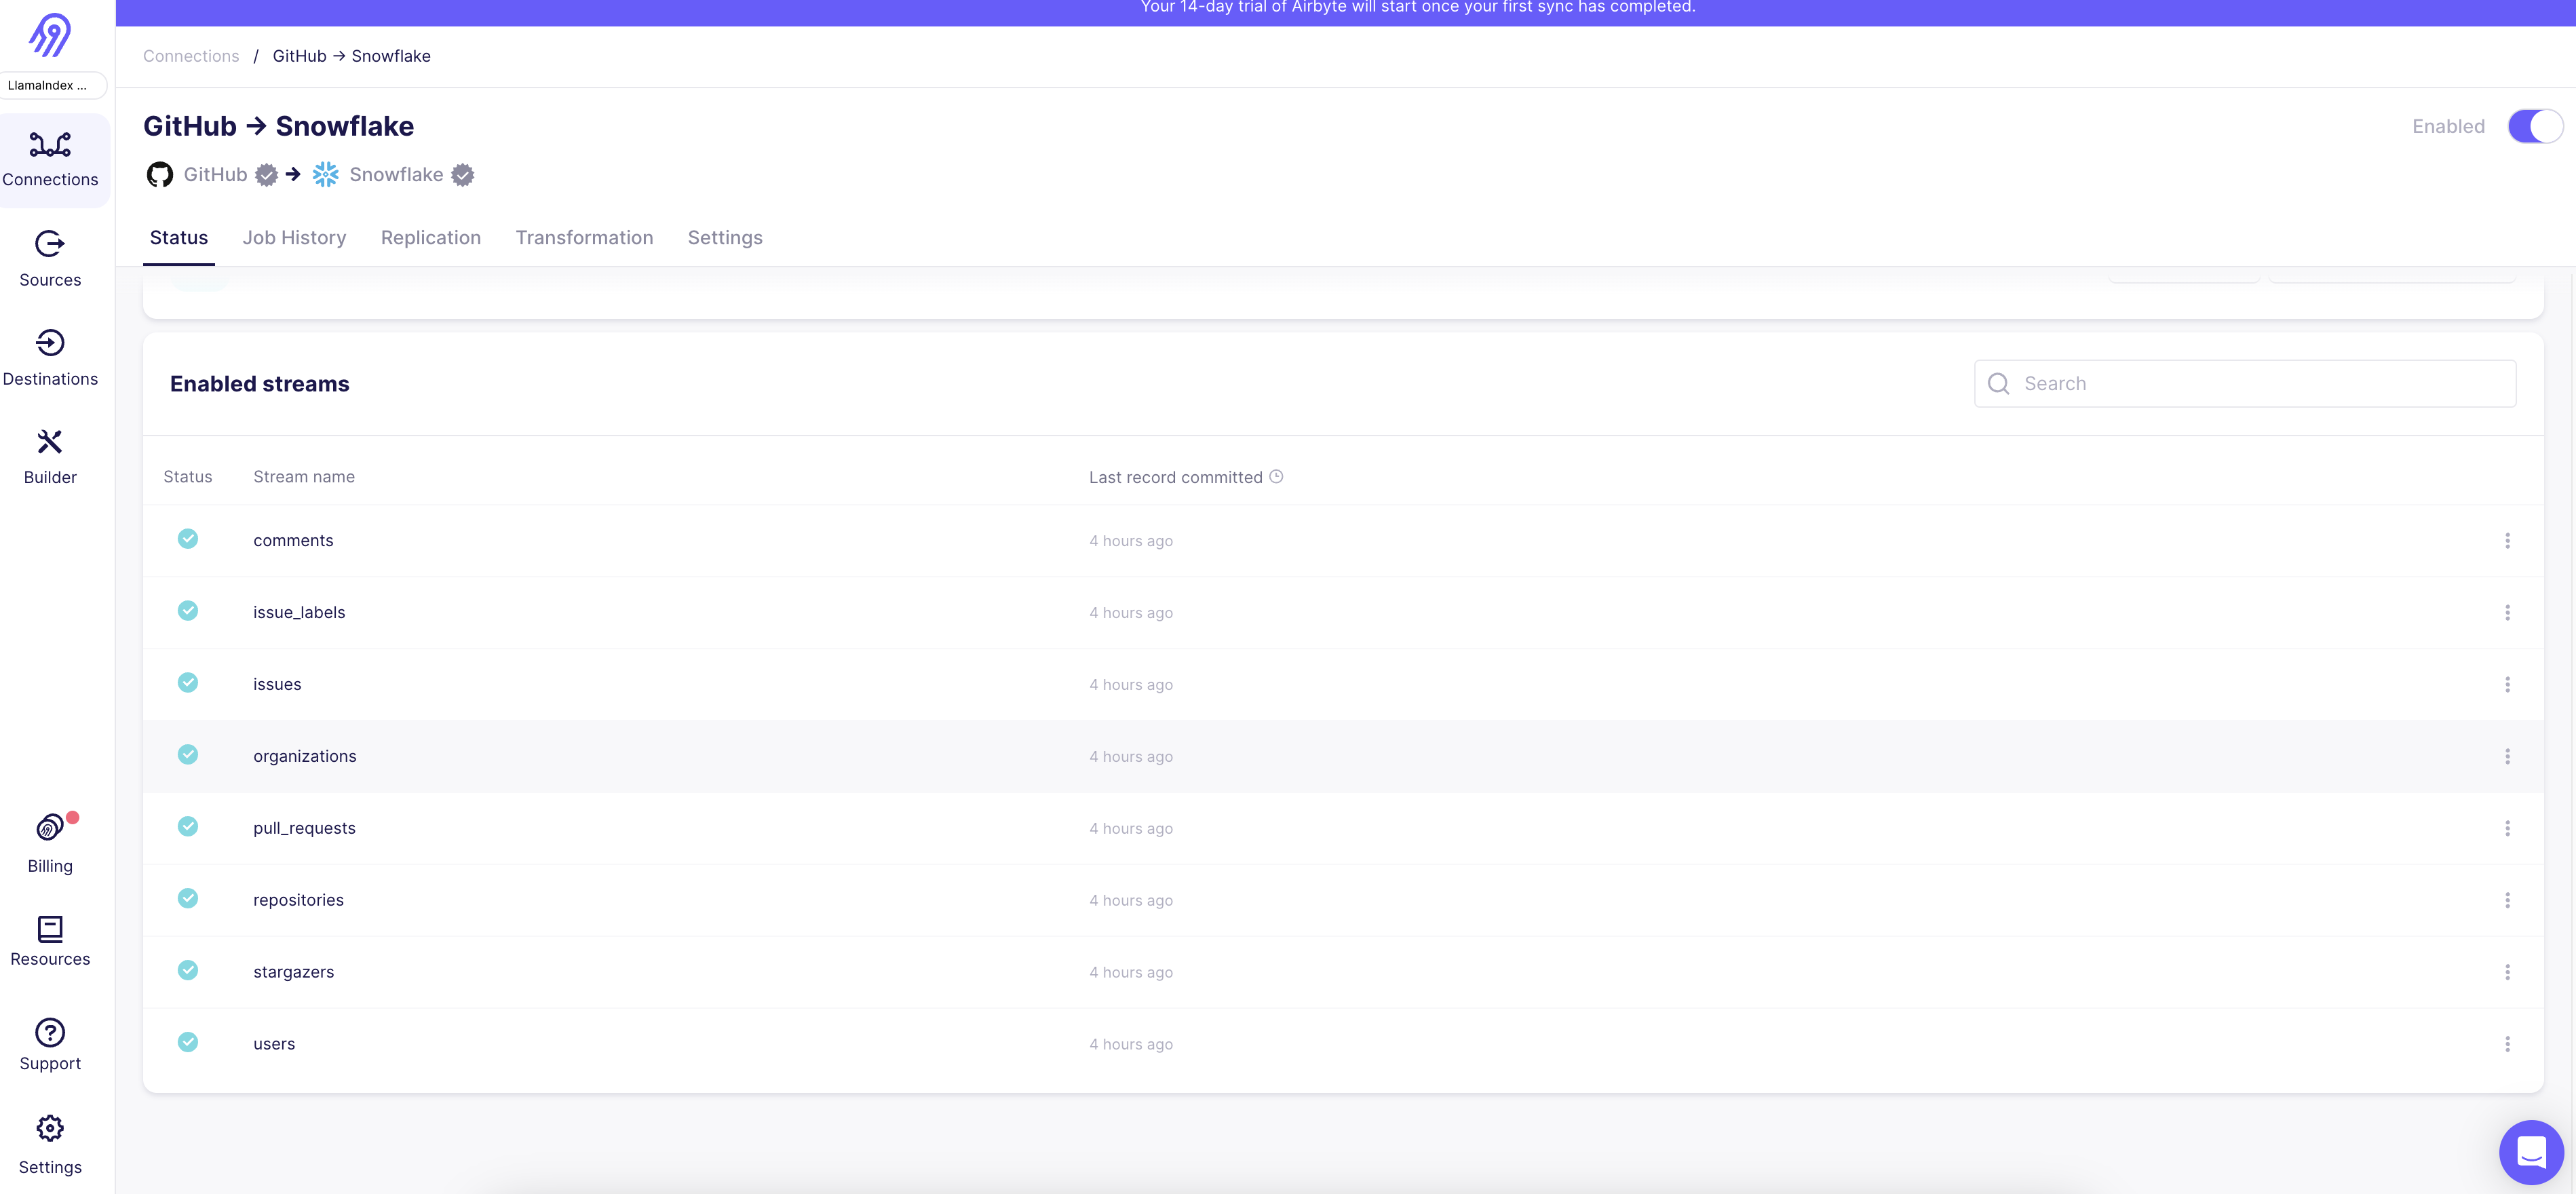

In [ ]:
Image(filename="img/github_3.png")

Sync your data.

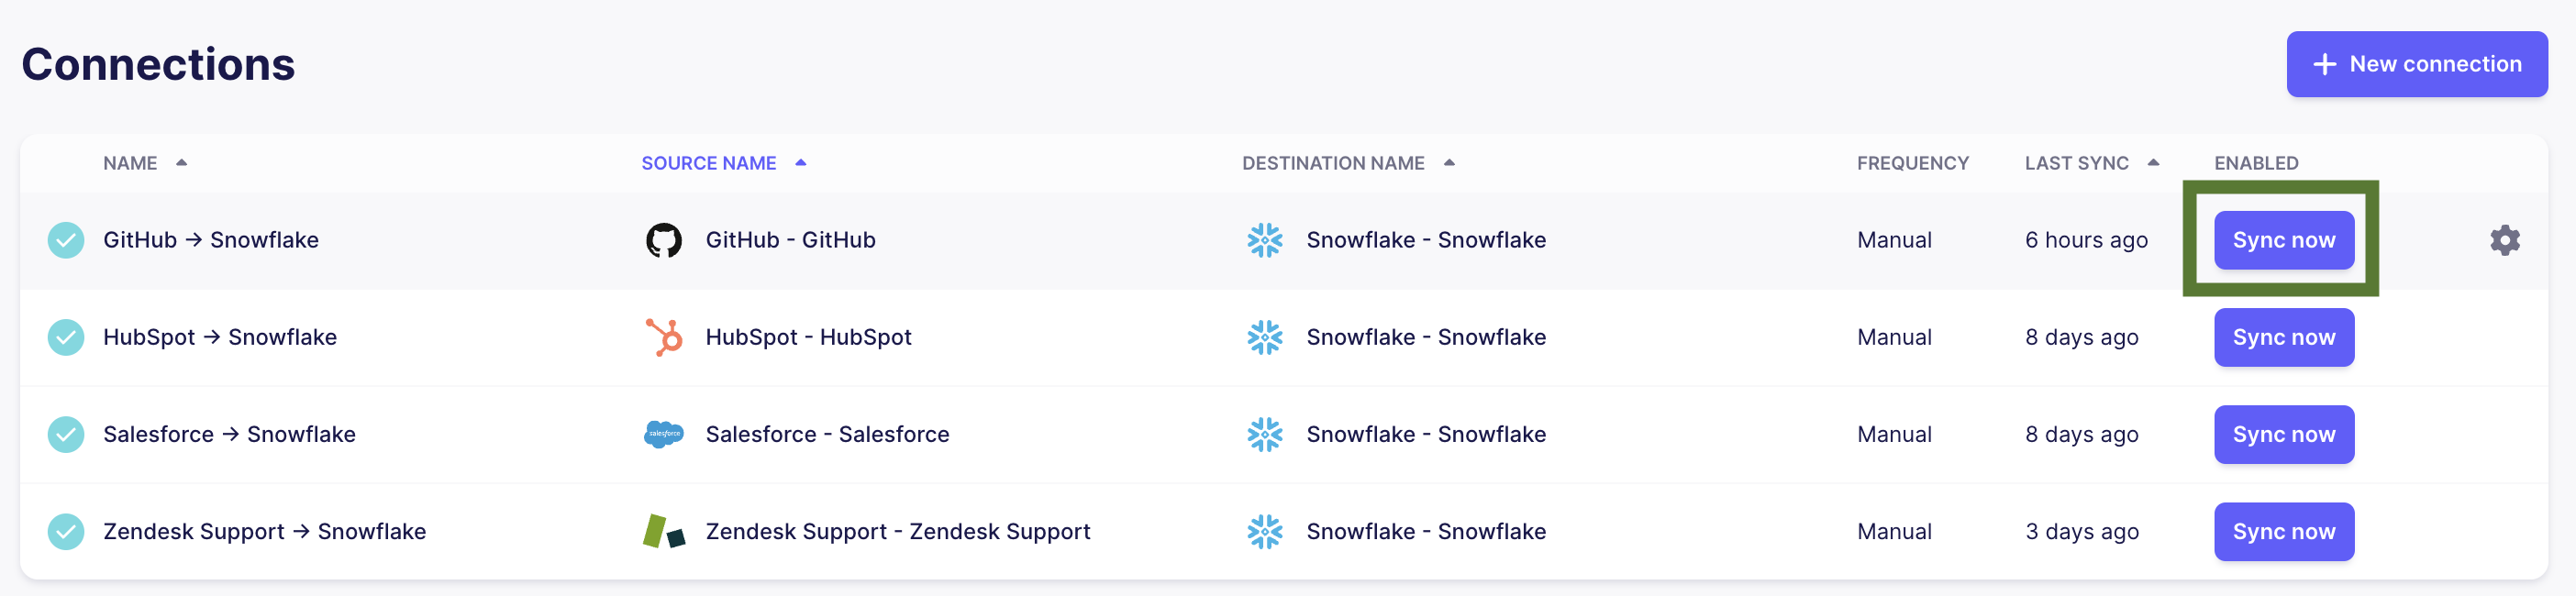

In [ ]:
Image(filename="img/airbyte_9.png")

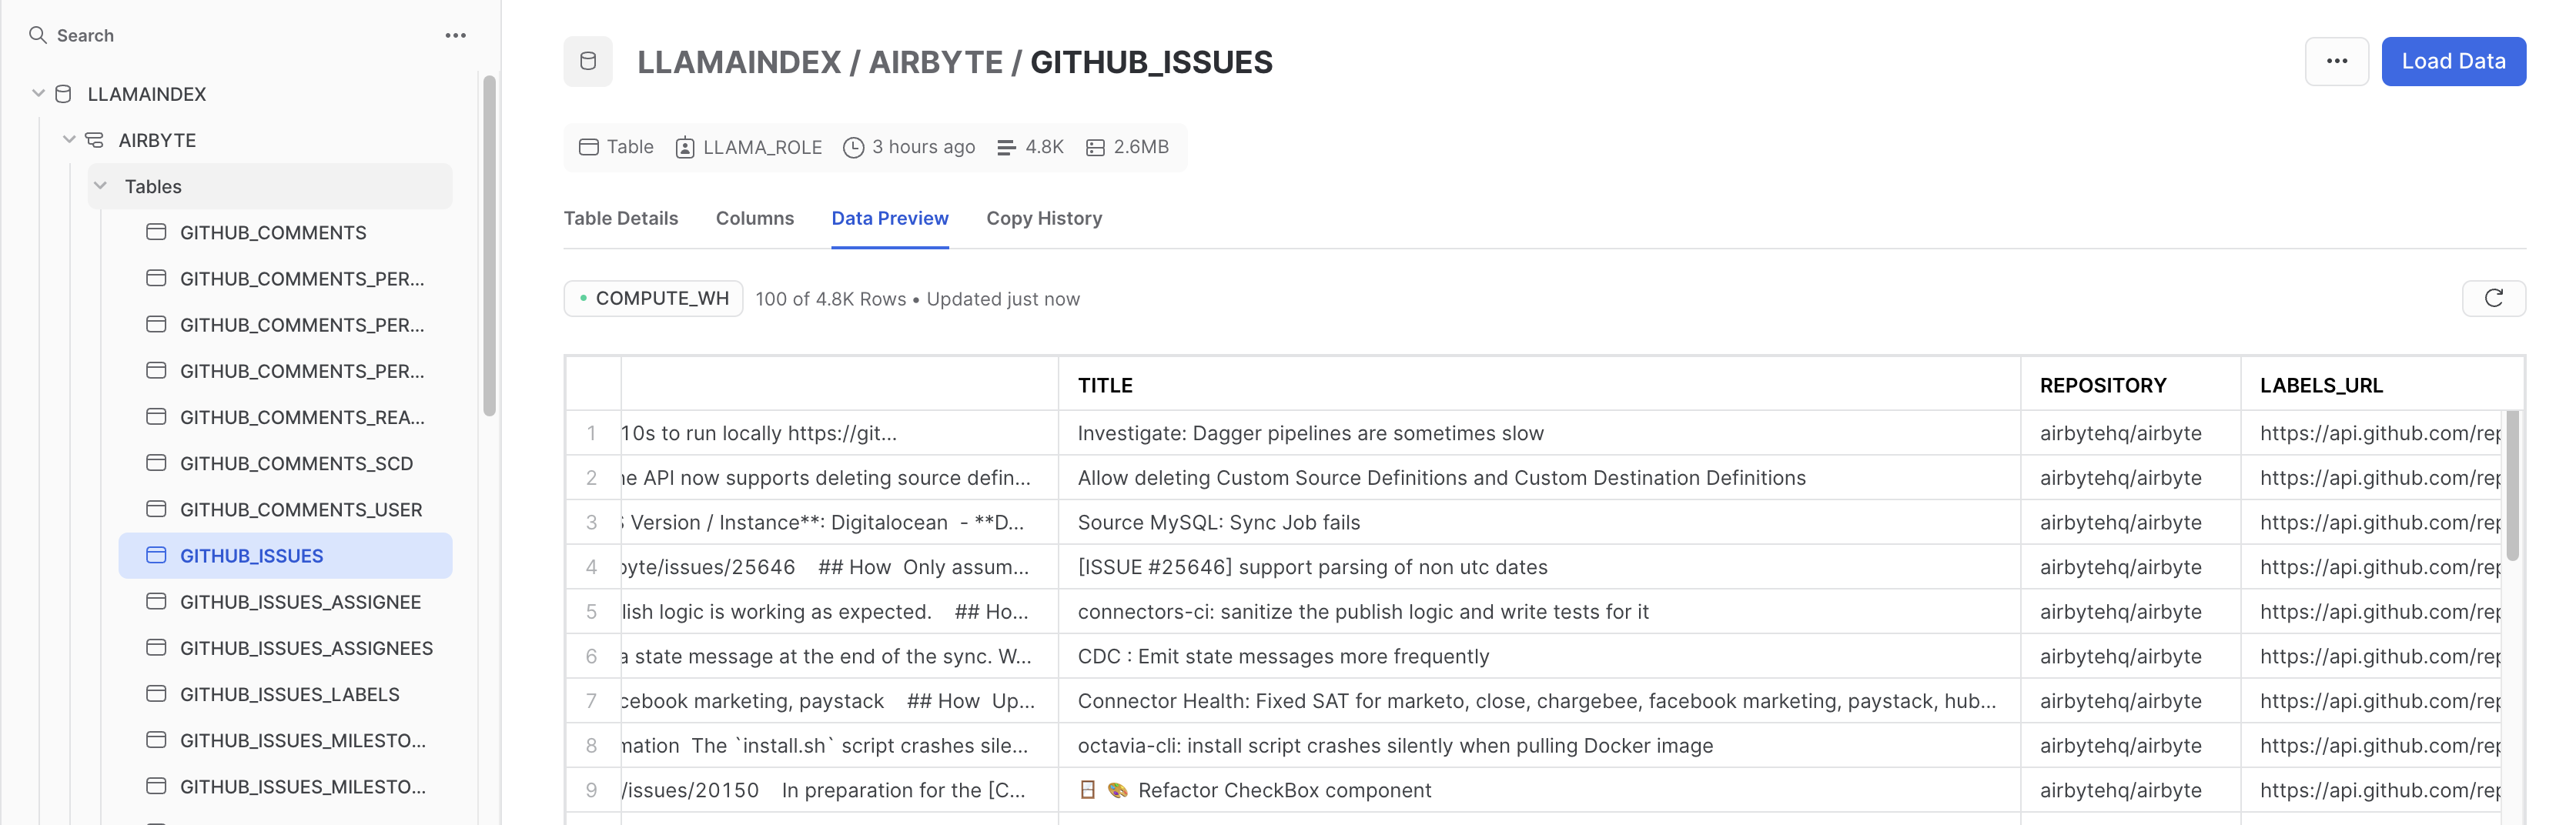

In [ ]:
Image(filename="img/airbyte_8.png")

### Snowflake-SQLAlchemy version fix

Hack to make snowflake-sqlalchemy work despite incompatible sqlalchemy versions

Taken from https://github.com/snowflakedb/snowflake-sqlalchemy/issues/380#issuecomment-1470762025

In [ ]:
# Hack to make snowflake-sqlalchemy work until they patch it


def snowflake_sqlalchemy_20_monkey_patches():
    import sqlalchemy.util.compat

    # make strings always return unicode strings
    sqlalchemy.util.compat.string_types = (str,)
    sqlalchemy.types.String.RETURNS_UNICODE = True

    import snowflake.sqlalchemy.snowdialect

    snowflake.sqlalchemy.snowdialect.SnowflakeDialect.returns_unicode_strings = (
        True
    )

    # make has_table() support the `info_cache` kwarg
    import snowflake.sqlalchemy.snowdialect

    def has_table(self, connection, table_name, schema=None, info_cache=None):
        """
        Checks if the table exists.
        """
        return self._has_object(connection, "TABLE", table_name, schema)

    snowflake.sqlalchemy.snowdialect.SnowflakeDialect.has_table = has_table


# usage: call this function before creating an engine:
try:
    snowflake_sqlalchemy_20_monkey_patches()
except Exception as e:
    raise ValueError("Please run `pip install snowflake-sqlalchemy`")

### Define database

We pass the Snowflake uri to the SQL db constructor

In [ ]:
snowflake_uri = "snowflake://<user_login_name>:<password>@<account_identifier>/<database_name>/<schema_name>?warehouse=<warehouse_name>&role=<role_name>"

First we try connecting with sqlalchemy to check the db works.

In [ ]:
from sqlalchemy import select, create_engine, MetaData, Table

# view current table
engine = create_engine(snowflake_uri)
metadata = MetaData(bind=None)
table = Table("ZENDESK_TICKETS", metadata, autoload=True, autoload_with=engine)
stmt = select(table.columns)


with engine.connect() as connection:
    results = connection.execute(stmt).fetchone()
    print(results)
    print(results.keys())

/var/folders/dx/n9yhm8p9039b5bgmgjqy46y40000gn/T/ipykernel_57673/3609487787.py:6: RemovedIn20Warning: Deprecated API features detected! These feature(s) are not compatible with SQLAlchemy 2.0. To prevent incompatible upgrades prior to updating applications, ensure requirements files are pinned to "sqlalchemy<2.0". Set environment variable SQLALCHEMY_WARN_20=1 to show all deprecation warnings.  Set environment variable SQLALCHEMY_SILENCE_UBER_WARNING=1 to silence this message. (Background on SQLAlchemy 2.0 at: https://sqlalche.me/e/b8d9)
  table = Table(


(False, 'test case', '[]', datetime.datetime(2022, 7, 18, 16, 59, 13, tzinfo=<UTC>), 'test to', None, None, 'question', '{\n  "channel": "web",\n  "source": {\n    "from": {},\n    "rel": null,\n    "to": {}\n  }\n}', True, datetime.datetime(2022, 7, 18, 18, 1, 37, tzinfo=<UTC>), None, '[]', None, 134, None, 1658167297, 'test case', None, '[]', False, '{\n  "score": "offered"\n}', 360786799676, 'low', '[]', 'https://d3v-airbyte.zendesk.com/api/v2/tickets/134.json', '[]', 360000358316, 360000084116, '[]', None, '[]', 360033549136, True, None, False, 'new', 360786799676, 'abd39a87-b1f9-4390-bf8b-cf3c288b1f74', datetime.datetime(2023, 6, 9, 0, 25, 23, 501000, tzinfo=pytz.FixedOffset(-420)), datetime.datetime(2023, 6, 9, 0, 38, 20, 440000, tzinfo=<UTC>), '6577ef036668746df889983970579a55', '02522a2b2726fb0a03bb19f2d8d9524d')
RMKeyView(['from_messaging_channel', 'subject', 'email_cc_ids', 'created_at', 'description', 'custom_status_id', 'external_id', 'type', 'via', 'allow_attachments', 'up

### Define SQL DB

Once we have defined the SQLDatabase, we can wrap it in a query engine to query it.
If we know what tables we want to use we can use `NLSQLTableQueryEngine`.
This will generate a SQL query on the specified tables.

In [ ]:
from llama_index import SQLDatabase

# You can specify table filters during engine creation.
# sql_database = SQLDatabase(engine, include_tables=["github_issues","github_comments", "github_users"])

sql_database = SQLDatabase(engine)

### Synthesize Query

We then show a natural language query, which is translated to a SQL query under the hood with our text-to-SQL prompt.

In [ ]:
from llama_index.indices.struct_store.sql_query import NLSQLTableQueryEngine
from IPython.display import Markdown, display

query_engine = NLSQLTableQueryEngine(
    sql_database=sql_database,
    tables=["github_issues", "github_comments", "github_users"],
)
query_str = "Which issues have the most comments? Give the top 10 and use a join on url."
response = query_engine.query(query_str)
display(Markdown(f"<b>{response}</b>"))

<b> The top 10 issues with the most comments, based on a join on url, are 'Proof of concept parallel source stream reading implementation for MySQL', 'Remove noisy logging for `LegacyStateManager`', 'Track stream status in source', 'Source Google Analytics v4: - add pk and lookback window', 'Connector Health: Fixed SAT for marketo, close, chargebee, facebook marketing, paystack, hubspot, pipedrive and marketo', '📝 Update outdated docs urls in metadata files', 'Fix emitted intermediate state for initial incremental non-CDC syncs', 'source-postgres : Add logic to handle xmin wraparound', ':bug: Source HubSpot: fix cast string as boolean using string comparison', and 'Fix db-lib JdbcUtils.java to accept JDBC parameters with = sign.'.</b>

In [ ]:
# You can also get only the SQL query result.

query_engine = NLSQLTableQueryEngine(
    sql_database=sql_database,
    synthesize_response=False,
    tables=["github_issues", "github_comments", "github_users"],
)
response = query_engine.query(query_str)
display(Markdown(f"<b>{response}</b>"))

<b>[('Proof of concept parallel source stream reading implementation for MySQL', 'https://api.github.com/repos/airbytehq/airbyte/issues/26580', 'https://api.github.com/repos/airbytehq/airbyte/issues/26580', 104), ('Remove noisy logging for `LegacyStateManager`', 'https://api.github.com/repos/airbytehq/airbyte/issues/27335', 'https://api.github.com/repos/airbytehq/airbyte/issues/27335', 39), ('Track stream status in source', 'https://api.github.com/repos/airbytehq/airbyte/issues/24971', 'https://api.github.com/repos/airbytehq/airbyte/issues/24971', 35), ('Source Google Analytics v4: - add pk and lookback window', 'https://api.github.com/repos/airbytehq/airbyte/issues/26283', 'https://api.github.com/repos/airbytehq/airbyte/issues/26283', 29), ('Connector Health: Fixed SAT for marketo, close, chargebee, facebook marketing, paystack, hubspot, pipedrive and marketo', 'https://api.github.com/repos/airbytehq/airbyte/issues/24802', 'https://api.github.com/repos/airbytehq/airbyte/issues/24802', 28), ('📝 Update outdated docs urls in metadata files', 'https://api.github.com/repos/airbytehq/airbyte/issues/27420', 'https://api.github.com/repos/airbytehq/airbyte/issues/27420', 26), ('Fix emitted intermediate state for initial incremental non-CDC syncs', 'https://api.github.com/repos/airbytehq/airbyte/issues/24820', 'https://api.github.com/repos/airbytehq/airbyte/issues/24820', 25), ('source-postgres : Add logic to handle xmin wraparound', 'https://api.github.com/repos/airbytehq/airbyte/issues/27384', 'https://api.github.com/repos/airbytehq/airbyte/issues/27384', 24), (':bug: Source HubSpot: fix cast string as boolean using string comparison', 'https://api.github.com/repos/airbytehq/airbyte/issues/26082', 'https://api.github.com/repos/airbytehq/airbyte/issues/26082', 24), ('Fix db-lib JdbcUtils.java to accept JDBC parameters with = sign.', 'https://api.github.com/repos/airbytehq/airbyte/issues/25386', 'https://api.github.com/repos/airbytehq/airbyte/issues/25386', 22)]</b>

In [ ]:
# You can also get the original SQL query
sql_query = response.metadata["sql_query"]
display(Markdown(f"<b>{sql_query}</b>"))

<b>SELECT gi.title, gi.url, gc.issue_url, COUNT(*) AS comment_count 
FROM github_issues gi 
JOIN github_comments gc ON gi.url = gc.issue_url 
GROUP BY gi.title, gi.url, gc.issue_url 
ORDER BY comment_count DESC 
LIMIT 10;</b>

We can also use LLM prediction to figure out what tables to use.

We first need to create an ObjectIndex of SQLTableSchema. In this case we only pass in the table names.
The query engine will fetch the relevant table schema at query time.

In [ ]:
from llama_index.indices.struct_store.sql_query import (
    SQLTableRetrieverQueryEngine,
)
from llama_index.objects import (
    SQLTableNodeMapping,
    ObjectIndex,
    SQLTableSchema,
)
from llama_index import VectorStoreIndex

table_node_mapping = SQLTableNodeMapping(sql_database)
all_table_names = sql_database.get_usable_table_names()
table_schema_objs = []
for table_name in all_table_names:
    table_schema_objs.append(SQLTableSchema(table_name=table_name))

obj_index = ObjectIndex.from_objects(
    table_schema_objs,
    table_node_mapping,
    VectorStoreIndex,
)
table_retriever_query_engine = SQLTableRetrieverQueryEngine(
    sql_database, obj_index.as_retriever(similarity_top_k=1)
)
response = query_engine.query(query_str)

display(Markdown(f"<b>{response}</b>"))
sql_query = response.metadata["sql_query"]
display(Markdown(f"<b>{sql_query}</b>"))

/Users/hongyishi/Documents/GitHub/gpt_index/.venv/lib/python3.11/site-packages/langchain/sql_database.py:279: UserWarning: This method is deprecated - please use `get_usable_table_names`.
  warnings.warn(


<b>[('Proof of concept parallel source stream reading implementation for MySQL', 'https://api.github.com/repos/airbytehq/airbyte/issues/26580', 'https://api.github.com/repos/airbytehq/airbyte/issues/26580', 104), ('Remove noisy logging for `LegacyStateManager`', 'https://api.github.com/repos/airbytehq/airbyte/issues/27335', 'https://api.github.com/repos/airbytehq/airbyte/issues/27335', 39), ('Track stream status in source', 'https://api.github.com/repos/airbytehq/airbyte/issues/24971', 'https://api.github.com/repos/airbytehq/airbyte/issues/24971', 35), ('Source Google Analytics v4: - add pk and lookback window', 'https://api.github.com/repos/airbytehq/airbyte/issues/26283', 'https://api.github.com/repos/airbytehq/airbyte/issues/26283', 29), ('Connector Health: Fixed SAT for marketo, close, chargebee, facebook marketing, paystack, hubspot, pipedrive and marketo', 'https://api.github.com/repos/airbytehq/airbyte/issues/24802', 'https://api.github.com/repos/airbytehq/airbyte/issues/24802', 28), ('📝 Update outdated docs urls in metadata files', 'https://api.github.com/repos/airbytehq/airbyte/issues/27420', 'https://api.github.com/repos/airbytehq/airbyte/issues/27420', 26), ('Fix emitted intermediate state for initial incremental non-CDC syncs', 'https://api.github.com/repos/airbytehq/airbyte/issues/24820', 'https://api.github.com/repos/airbytehq/airbyte/issues/24820', 25), ('source-postgres : Add logic to handle xmin wraparound', 'https://api.github.com/repos/airbytehq/airbyte/issues/27384', 'https://api.github.com/repos/airbytehq/airbyte/issues/27384', 24), (':bug: Source HubSpot: fix cast string as boolean using string comparison', 'https://api.github.com/repos/airbytehq/airbyte/issues/26082', 'https://api.github.com/repos/airbytehq/airbyte/issues/26082', 24), ('Fix db-lib JdbcUtils.java to accept JDBC parameters with = sign.', 'https://api.github.com/repos/airbytehq/airbyte/issues/25386', 'https://api.github.com/repos/airbytehq/airbyte/issues/25386', 22)]</b>

<b>SELECT gi.title, gi.url, gc.issue_url, COUNT(*) AS comment_count 
FROM github_issues gi 
JOIN github_comments gc ON gi.url = gc.issue_url 
GROUP BY gi.title, gi.url, gc.issue_url 
ORDER BY comment_count DESC 
LIMIT 10;</b>